# Evaluate the impact of enviromental variables on TC prediction
 -  compare monthly climatology of relevant variables between S2S and obseravtoins
 -  compare GPI
 -  compare GPI by replacing each term with observation
 -  evaluate ensemble spread

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import hvplot.xarray
import matplotlib
import matplotlib.pyplot as plt
import time
import dask
import warnings
warnings.filterwarnings('ignore')

In [2]:
from geocat.viz import util as gvutil
from geocat.viz import cmaps as gvcmaps

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

## Set up: define plotting functions

In [68]:
def compare_climatology_bylead(var,basin):
    fig, ax1 = plt.subplots(figsize=(8, 8))
    fig.tight_layout(pad=4)


    if (basin==0):
        var = var.sel(lat =slice(5,30),lon=slice(280,360)).mean(('lat','lon'))
    elif (basin==1):
        var = var.sel(lat=slice(5,30),lon=slice(230,280)).mean(('lat','lon'))
    elif (basin==2):
        var = var.sel(lat=slice(5,20),lon=slice(80,100)).mean(('lat','lon'))
    elif (basin==3):
        var = var.sel(lat=slice(5,30),lon=slice(110,180)).mean(('lat','lon'))
    elif (basin==4):
        var = var.sel(lat=slice(-30,-5),lon=slice(40,280)).mean(('lat','lon'))

    # week1
    for iw in np.arange(0,6):
        var[iw].plot(ax = ax1,label ='week '+(iw+1).astype(str),linewidth = 2)

    ax1.plot(np.arange(1,13),np.zeros(12),color='black',linestyle='--')


    ax1.set_xlim(1,12)
    
    ax1.set_xlabel("month",fontsize=12)
    ax1.set_xticks(np.arange(1,13))

# plt.subplots_adjust(top=0.85)
    ax1.legend()


    plt.show()

In [410]:
## define gpi plotting funcition
def var_plot_panels(variable, i,j, ax1, levels, colormap, title,colorbar):
    ax1= fig.add_subplot(spec[i,j], projection=ccrs.PlateCarree(central_longitude=180))
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                           extend='both',
                            cmap = colormap,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
    if colorbar==True:
        plt.colorbar(contour,
                     ax=ax1,
                     ticks=np.arange(0,20),
                     orientation='horizontal',
                     pad=0.075,
                     drawedges=True,
                     shrink=0.7)

    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=15)
    gvutil.set_axes_limits_and_ticks(ax1, xlim=(-110, 170),
                                 ylim=(0, 40),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

    gvutil.add_major_minor_ticks(ax1, labelsize=12)
    gvutil.add_lat_lon_ticklabels(ax1)


In [414]:
## define gpi plotting funcition
def var_plot_panels_winter(variable, i,j, ax1, levels, colormap, title,colorbar):
    ax1= fig.add_subplot(spec[i,j], projection=ccrs.PlateCarree(central_longitude=180))
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                           extend='both',
                            cmap = colormap,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
    if colorbar==True:
        plt.colorbar(contour,
                     ax=ax1,
                     ticks=np.arange(0,20),
                     orientation='horizontal',
                     pad=0.075,
                     drawedges=True,
                     shrink=0.7)

    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=15)
    gvutil.set_axes_limits_and_ticks(ax1, xlim=(-150, 100),
                                 ylim=(-40, 0),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

    gvutil.add_major_minor_ticks(ax1, labelsize=12)
    gvutil.add_lat_lon_ticklabels(ax1)


## 1. read in observational climatology from jra55: PSL, vo850, rh700 and shear, SST from oisst,


In [9]:
dsst = xr.open_dataset('/glade/work/huili7/S2S/clim_data/oisst_climatology_2002-2019.nc')
sst = dsst.t

ds_ps = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_ps_2002-2019.nc')
ps = ds_ps.sp


In [10]:
omega = 7.2921 * 1e-5 #rad/s
dsv = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_uv850_2002-2019.nc')
vor = dsv.vo + 2 * omega * np.sin(np.deg2rad(dsv.latitude)) 
u850 = dsv.u
v850 = dsv.v

dsv2 = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_uv200_2002-2019.nc')
u200 = dsv2.u
v200 = dsv2.v

dsr = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_rh700_2002-2019.nc')
rh700 = dsr.r

dsmask = xr.open_dataset('/gpfs/fs1/collections/rda/data/ds277.0/climatology/lsmask.nc')
lsm=dsmask.mask

dvmax = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra_pi_VMAX.nc')
vmax = dvmax.VMAX

In [11]:
shear = np.sqrt((u200 - u850)**2 + (v200-v850)**2) 

In [12]:
lsm1 = lsm.rename({'lat':'latitude'})
lsm2 = lsm1.rename({'lon':'longitude'})
sst = sst.where(lsm2[0]==1)
sst = sst - 273.15



## read in ERAI data

In [46]:
omega = 7.2921 * 1e-5 #rad/s

# dsst_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_sst_2002-2018.nc')
# sst_e  = dsst_e.sst

# dps_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_psl_2002-2018.nc')
# psl_e  = dps_e.msl

# dsvr_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_vr850_2002-2018.nc')
# vor_e = dsvr_e.vo + 2 * omega * np.sin(np.deg2rad(dsvr_e.latitude)) 

# dsv_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_uv850_2002-2018.nc')
# u850_e = dsv_e.u
# v850_e = dsv_e.v

# dsv2_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_uv200_2002-2018.nc')
# u200_e = dsv2_e.u
# v200_e = dsv2_e.v

# dsr_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_rh700_2002-2018.nc')
# rh700_e = dsr_e.r

# #dsmask = xr.open_dataset('/gpfs/fs1/collections/rda/data/ds277.0/climatology/lsmask.nc')
# #lsm=dsmask.mask

# shear_e = np.sqrt((u200_e - u850_e)**2 + (v200_e-v850_e)**2) 

## 2. Read in S2S climatology

In [13]:
sst_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    dsst = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_sst_week'+week+'_monclim.nc')
    sst_list.append(dsst.SST)
S2S_sst = xr.concat(sst_list,dim='week')
S2S_sst['week'] = np.arange(1,7)

In [14]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_psl_week'+week+'_monclim.nc')
    var_list.append(ds.PSL)
S2S_psl = xr.concat(var_list,dim='week')
S2S_psl['week'] = np.arange(1,7)

In [15]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_ua850_week'+week+'_monclim.nc')
    var_list.append(ds.ua_850)
S2S_ua850 = xr.concat(var_list,dim='week')
S2S_ua850['week'] = np.arange(1,7)

In [16]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_va850_week'+week+'_monclim.nc')
    var_list.append(ds.va_850)
S2S_va850 = xr.concat(var_list,dim='week')
S2S_va850['week'] = np.arange(1,7)

In [17]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_ua200_week'+week+'_monclim.nc')
    var_list.append(ds.ua_200)
S2S_ua200 = xr.concat(var_list,dim='week')
S2S_ua200['week'] = np.arange(1,7)

In [18]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_va200_week'+week+'_monclim.nc')
    var_list.append(ds.va_200)
S2S_va200 = xr.concat(var_list,dim='week')
S2S_va200['week'] = np.arange(1,7)

In [19]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_rh700_week'+week+'_monclim.nc')
    var_list.append(ds.RELHUM)
S2S_rh700 = xr.concat(var_list,dim='week')
S2S_rh700['week'] = np.arange(1,7)

In [20]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_vor850_week'+week+'_monclim.nc')
    var_list.append(ds.vo)
S2S_vo850_raw = xr.concat(var_list,dim='week')
S2S_vo850_raw['week'] = np.arange(1,7)

In [21]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_pi_VMAX_week'+week+'.nc')
    var_list.append(ds.VMAX)
S2S_vmax = xr.concat(var_list,dim='week')
S2S_vmax['week'] = np.arange(1,7)

In [22]:
S2S_shear_raw = np.sqrt((S2S_ua200 - S2S_ua850)**2 + (S2S_va200-S2S_va850)**2) 

In [30]:
S2S_shear_raw

<xarray.DataArray (week: 6, month: 12, member: 10, lat: 181, lon: 360)>
array([[[[[ 4.789222  ,  4.7890387 ,  4.7889485 , ...,  4.7889495 ,
            4.7889485 ,  4.78904   ],
          [ 4.99594   ,  4.988256  ,  4.980027  , ...,  5.0154324 ,
            5.0089254 ,  5.002481  ],
          [ 5.623111  ,  5.6167397 ,  5.609249  , ...,  5.6338315 ,
            5.6310906 ,  5.627787  ],
          ...,
          [ 3.8972087 ,  3.9051733 ,  3.912605  , ...,  3.8697793 ,
            3.8793366 ,  3.8885021 ],
          [ 3.2239382 ,  3.228183  ,  3.232252  , ...,  3.2099047 ,
            3.2147408 ,  3.219446  ],
          [ 2.6626353 ,  2.6625705 ,  2.6625288 , ...,  2.6625147 ,
            2.6625125 ,  2.6625597 ]],

         [[ 4.386286  ,  4.386119  ,  4.386036  , ...,  4.3860354 ,
            4.3860354 ,  4.386119  ],
          [ 4.653543  ,  4.6458554 ,  4.6373897 , ...,  4.674686  ,
            4.6677675 ,  4.660826  ],
          [ 5.320128  ,  5.3124456 ,  5.303837  , ...,  5.335817  ,
            5.3318458 ,  5.326889  ],
...
          [ 3.2280161 ,  3.2373946 ,  3.2463067 , ...,  3.1954393 ,
            3.206793  ,  3.2176442 ],
          [ 2.4158525 ,  2.4187622 ,  2.4214845 , ...,  2.404706  ,
            2.4086952 ,  2.4124205 ],
          [ 1.8978298 ,  1.897757  ,  1.8977208 , ...,  1.8977236 ,
            1.8977214 ,  1.8977572 ]],

         [[ 5.5498753 ,  5.5496655 ,  5.5495596 , ...,  5.549562  ,
            5.5495605 ,  5.549666  ],
          [ 5.958294  ,  5.9475813 ,  5.936183  , ...,  5.987681  ,
            5.9779034 ,  5.968322  ],
          [ 6.6416183 ,  6.6257315 ,  6.6089015 , ...,  6.682459  ,
            6.6700463 ,  6.6563983 ],
          ...,
          [ 3.45762   ,  3.462244  ,  3.4665575 , ...,  3.4401352 ,
            3.4463587 ,  3.4521773 ],
          [ 2.656649  ,  2.6587596 ,  2.6605966 , ...,  2.648066  ,
            2.6511655 ,  2.653998  ],
          [ 1.9577208 ,  1.9576474 ,  1.9576082 , ...,  1.9576099 ,
            1.9576099 ,  1.9576467 ]]]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * week     (week) int64 1 2 3 4 5 6

###  change SST unit

In [47]:
sst_e = sst_e - 273.15

In [23]:
S2S_sst = S2S_sst.where(S2S_sst>0)
S2S_sst = S2S_sst -273.15

## regrid erai observational data

In [52]:
# sste_regrid = sst_e.interp(latitude=S2S_sst.lat, longitude = S2S_sst.lon, method='linear')
# pse_regrid = psl_e.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')
# sheare_regrid = shear_e.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')
# voe_regrid = vor_e.interp(latitude = S2S_sst.lat, longitude = S2S_sst.lon, method='linear')
# rhe_regrid = rh700_e.interp(latitude = S2S_sst.lat, longitude = S2S_sst.lon, method='linear')


### regrid jra55 observtional data

In [24]:
ssto_regrid = sst.interp(latitude=S2S_sst.lat, longitude = S2S_sst.lon, method='linear')

# regrid observational ps
pso_regrid = ps.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')


# regrid model observational wind shear
shearo_regrid = shear.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')

# regrid obs 850hpa vorticity
vo_regrid = vor.interp(latitude = S2S_sst.lat, longitude = S2S_sst.lon, method='linear')

# regrid relative humidity at 700 hPa
rh700o_regrid = rh700.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')
vmaxo_regrid = vmax.interp(latitude=S2S_sst.lat,longitude = S2S_sst.lon, method='linear')

### regrid S2S shear and vorticity data, because they are on the different grid who knows why

In [25]:
S2S_shear= S2S_shear_raw.interp(lat = S2S_sst.lat,lon = S2S_sst.lon, method='linear')
S2S_vo850= S2S_vo850_raw.interp(lat = S2S_sst.lat,lon = S2S_sst.lon, method='linear')

## 3. diagnostics of climatology

In [74]:
# sst_diff =S2S_sst.isel(member=0).copy(data=S2S_sst.mean('member').data - sste_regrid.data)

# ps_diff = S2S_psl.isel(member=0).copy(data=S2S_psl.mean('member').data-pse_regrid.data)

# shear_diff = S2S_shear.isel(member=0).copy(data=S2S_shear.mean('member').data -sheare_regrid.data)

# vo_diff = S2S_vo850.isel(member=0).copy(data=S2S_vo850.mean('member').data - voe_regrid.data)

# rh_diff = S2S_rh700.isel(member=0).copy(data = S2S_rh700.mean('member').data - rhe_regrid.data)

In [73]:
sst_diff =S2S_sst.isel(member=0).copy(data=S2S_sst.mean('member').data - ssto_regrid.data)
ps_diff = S2S_psl.isel(member=0).copy(data=S2S_psl.mean('member').data-pso_regrid.data)
shear_diff = S2S_shear.isel(member=0).copy(data=S2S_shear.mean('member').data -shearo_regrid.data)
vo_diff = S2S_vo850.isel(member=0).copy(data=S2S_vo850.mean('member').data - vo_regrid.data)
rh_diff = S2S_rh700.isel(member=0).copy(data = S2S_rh700.mean('member').data - rh700o_regrid.data)

In [75]:
ps_diff = ps_diff * 0.01
ps_diff = ps_diff.where(np.isfinite(sst_diff))

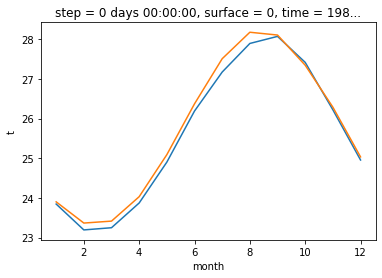

In [74]:
S2S_sst.sel(week=6,lat=slice(0,40), lon=slice(120,200)).mean(('member','lat','lon')).plot()
ssto_regrid.sel(lat=slice(0,40), lon=slice(120,200)).mean(('lat','lon')).plot()

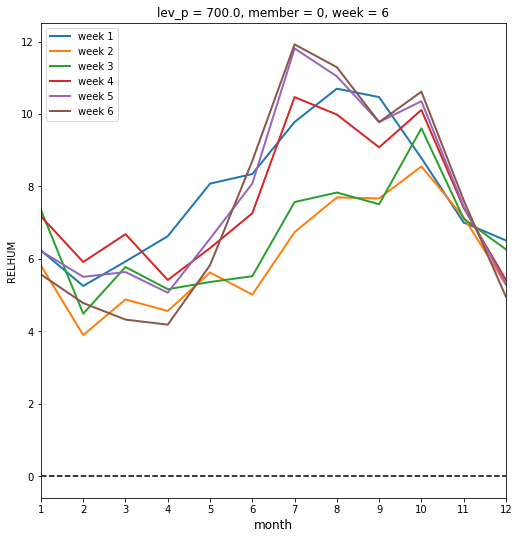

In [102]:
compare_climatology_bylead(rh_diff_o, 3)

In [76]:
sst_n_summer = sst_diff.sel(month=slice(5,10)).mean('month')
ps_n_summer = ps_diff.sel(month=slice(5,10)).mean('month')
shear_n_summer = shear_diff.sel(month=slice(5,10)).mean('month')
rh_n_summer = rh_diff.sel(month=slice(5,10)).mean('month')
vo_n_summer = vo_diff.sel(month=slice(5,10)).mean('month')

In [77]:
sst_n_winter = sst_diff.sel(month=[1,2,3,4,12]).mean('month')
ps_n_winter = ps_diff.sel(month=[1,2,3,4,12]).mean('month')
shear_n_winter = shear_diff.sel(month=[1,2,3,4,12]).mean('month')
rh_n_winter = rh_diff.sel(month=[1,2,3,4,12]).mean('month')
vo_n_winter = vo_diff.sel(month=[1,2,3,4,12]).mean('month')

In [78]:
sst_n_summer_diff = sst_n_summer.copy(data=sst_n_summer.data - sst_n_summer[0].data)
ps_n_summer_diff = ps_n_summer.copy(data=ps_n_summer.data - ps_n_summer[0].data)
shear_n_summer_diff = shear_n_summer.copy(data=shear_n_summer.data - shear_n_summer[0].data)
rh_n_summer_diff = rh_n_summer.copy(data=rh_n_summer.data - rh_n_summer[0].data)
vo_n_summer_diff = vo_n_summer.copy(data=vo_n_summer.data - vo_n_summer[0].data)


In [79]:
sst_n_winter_diff = sst_n_winter.copy(data=sst_n_winter.data - sst_n_winter[0].data)
ps_n_winter_diff = ps_n_winter.copy(data=ps_n_winter.data - ps_n_winter[0].data)
shear_n_winter_diff = shear_n_winter.copy(data=shear_n_winter.data - shear_n_winter[0].data)
rh_n_winter_diff = rh_n_winter.copy(data=rh_n_winter.data - rh_n_winter[0].data)
vo_n_winter_diff = vo_n_winter.copy(data=vo_n_winter.data - vo_n_winter[0].data)


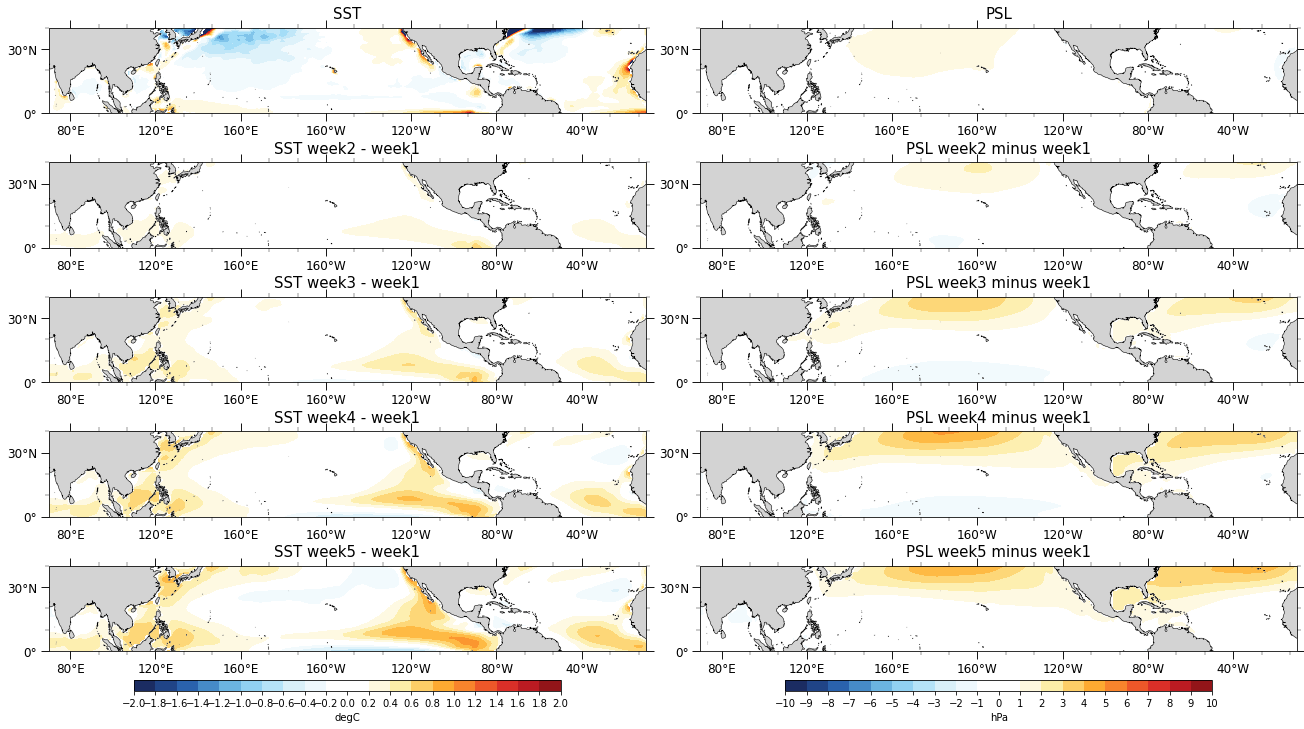

In [411]:
levels=np.linspace(-2,2, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot SST
var_plot_panels(sst_n_summer[0],0,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"SST", False)

for i in np.arange(1,5):
    var_plot_panels(sst_n_summer_diff[i],i,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"SST week"+(i+1).astype(str)+" - week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = np.linspace(-2,2,21).tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('degC')




# plot psl
levels=np.linspace(-10,10, 21)
cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels(ps_n_summer[0],0,1,ax1,levels,cmap,"PSL", False)

for i in np.arange(1,5):
    var_plot_panels(ps_n_summer_diff[i],i,1,ax1,levels,cmap,"PSL week"+(i+1).astype(str)+" minus week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('hPa')

#plt.show()


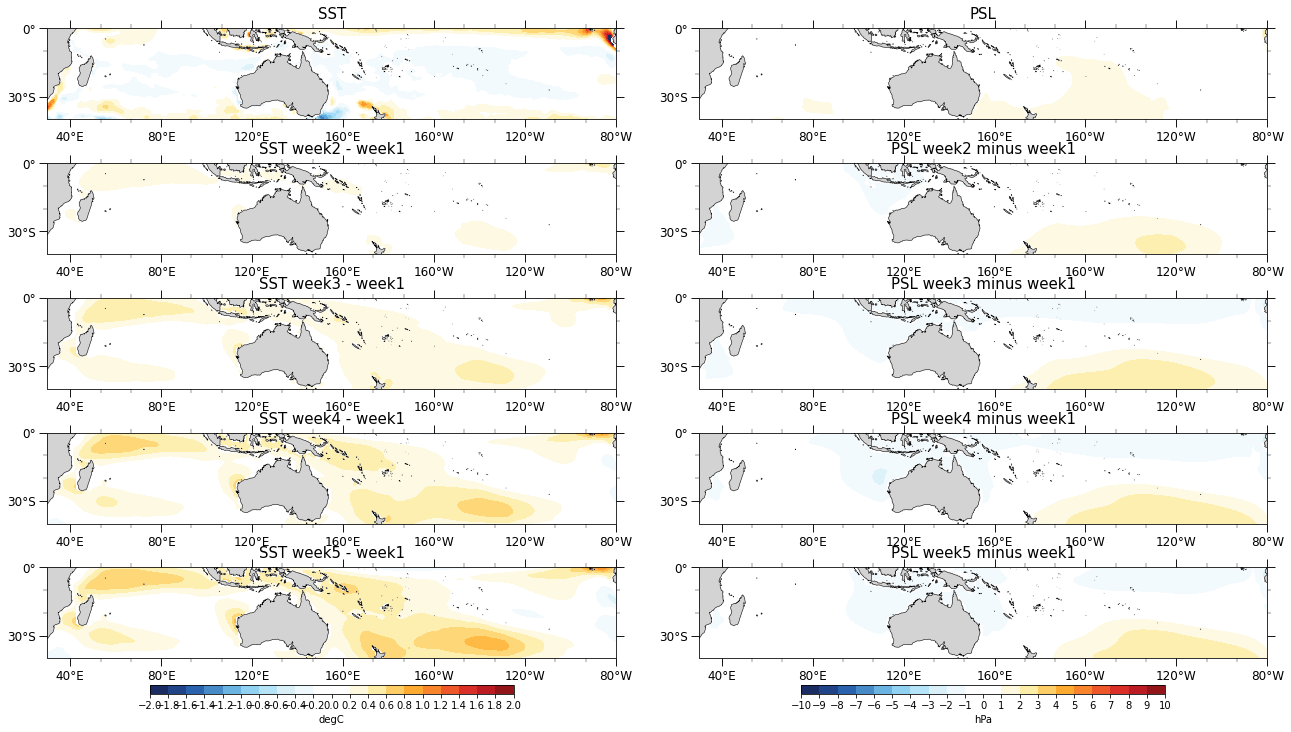

In [415]:
levels=np.linspace(-2,2, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot SST
var_plot_panels_winter(sst_n_winter[0],0,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"SST", False)

for i in np.arange(1,5):
    var_plot_panels_winter(sst_n_winter_diff[i],i,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"SST week"+(i+1).astype(str)+" - week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = np.linspace(-2,2,21).tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('degC')




# plot psl
levels=np.linspace(-10,10, 21)
cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels_winter(ps_n_winter[0],0,1,ax1,levels,cmap,"PSL", False)

for i in np.arange(1,5):
    var_plot_panels_winter(ps_n_winter_diff[i],i,1,ax1,levels,cmap,"PSL week"+(i+1).astype(str)+" minus week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('hPa')

#plt.show()


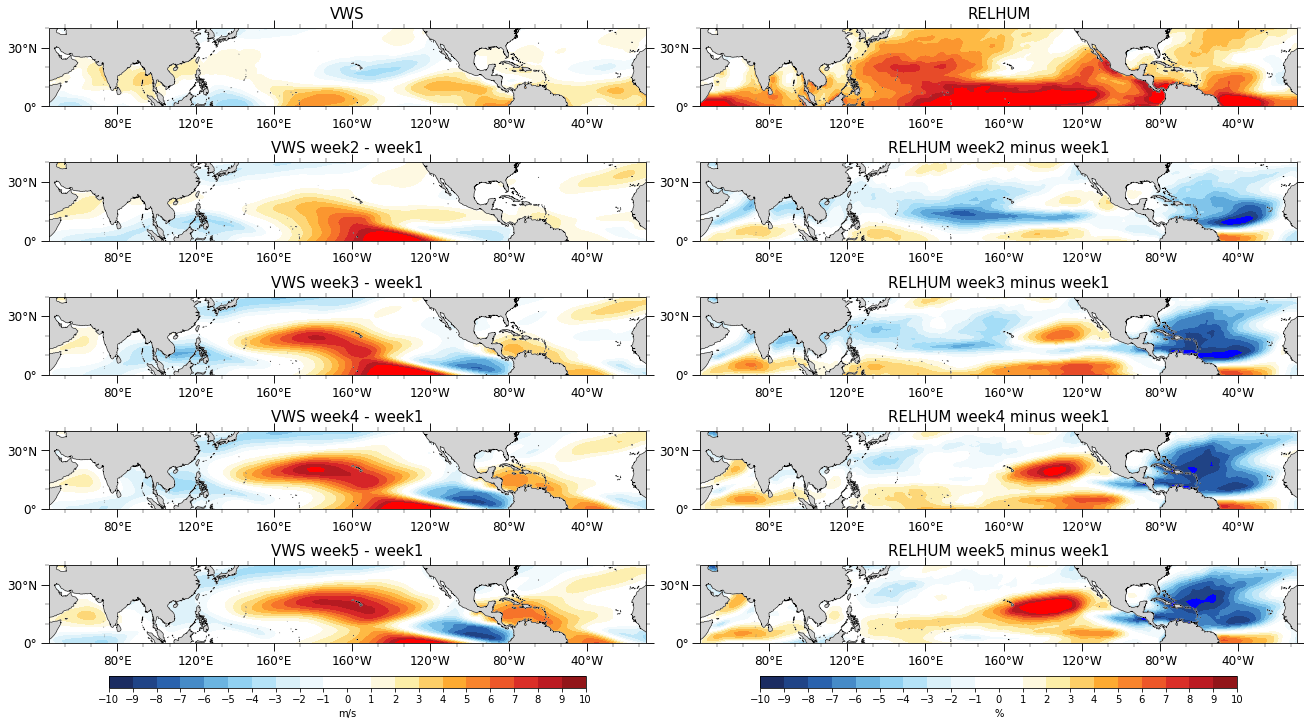

In [320]:
levels=np.linspace(-10,10, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot wind shear
var_plot_panels(shear_n_summer[0],0,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"VWS", False)

for i in np.arange(1,5):
    var_plot_panels(shear_n_summer_diff[i],i,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"VWS week"+(i+1).astype(str)+" - week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




# plot rh700
levels=np.linspace(-10,10, 21)
cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels(rh_n_summer[0],0,1,ax1,levels,cmap,"RELHUM", False)

for i in np.arange(1,5):
    var_plot_panels(rh_n_summer_diff[i],i,1,ax1,levels,cmap,"RELHUM week"+(i+1).astype(str)+" minus week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('%')

#plt.show()


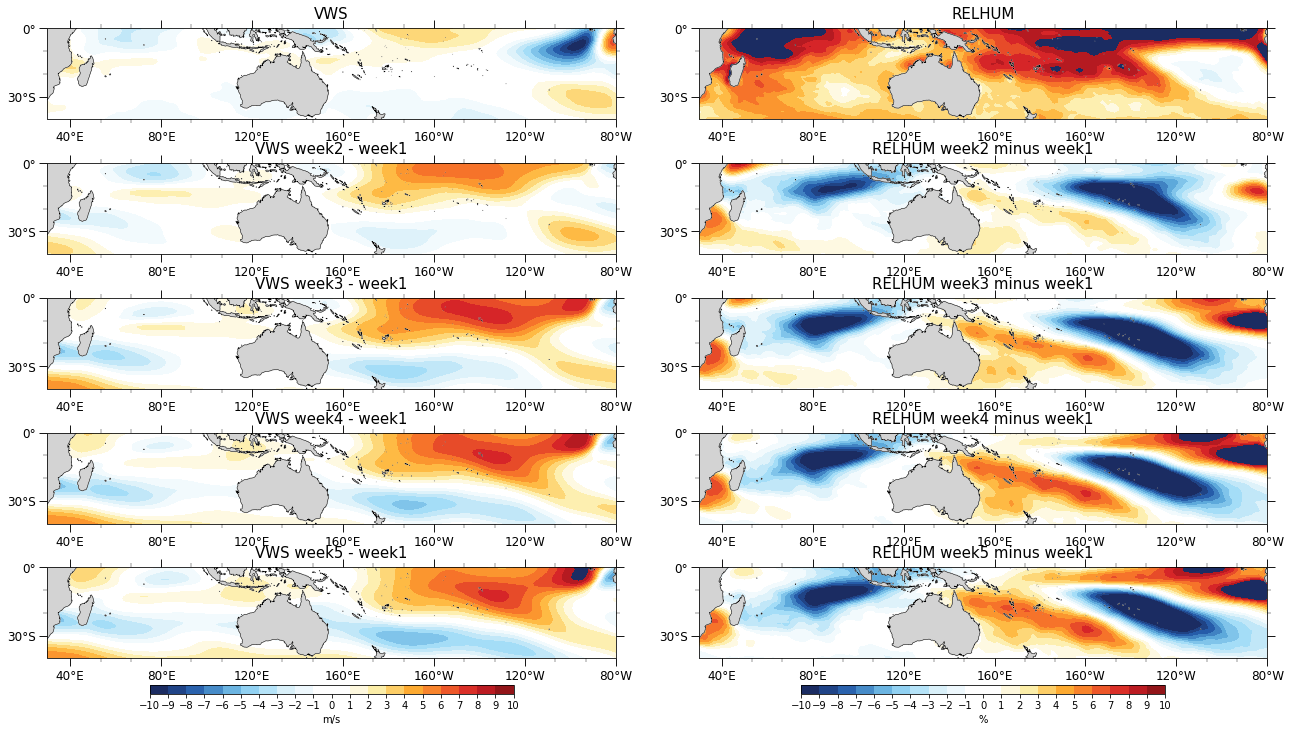

In [506]:
levels=np.linspace(-10,10, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot wind shear
var_plot_panels_winter(shear_n_winter[0],0,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"VWS", False)

for i in np.arange(1,5):
    var_plot_panels_winter(shear_n_winter_diff[i],i,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"VWS week"+(i+1).astype(str)+" - week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




# plot rh700
levels=np.linspace(-10,10, 21)
cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels_winter(rh_n_winter[0],0,1,ax1,levels,cmap,"RELHUM", False)

for i in np.arange(1,5):
    var_plot_panels_winter(rh_n_winter_diff[i],i,1,ax1,levels,cmap,"RELHUM week"+(i+1).astype(str)+" minus week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('%')

#plt.show()


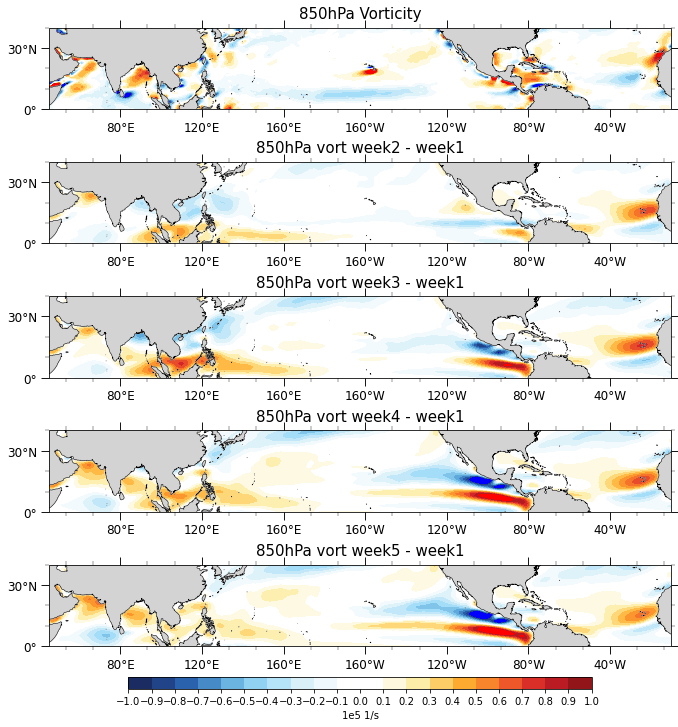

In [325]:
levels=np.linspace(-1,1, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot wind shear
var_plot_panels(1e5*vo_n_summer[0],0,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"850hPa Vorticity", False)

for i in np.arange(1,5):
    var_plot_panels(1e5*vo_n_summer_diff[i],i,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"850hPa vort week"+(i+1).astype(str)+" - week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('1e-5 1/s')





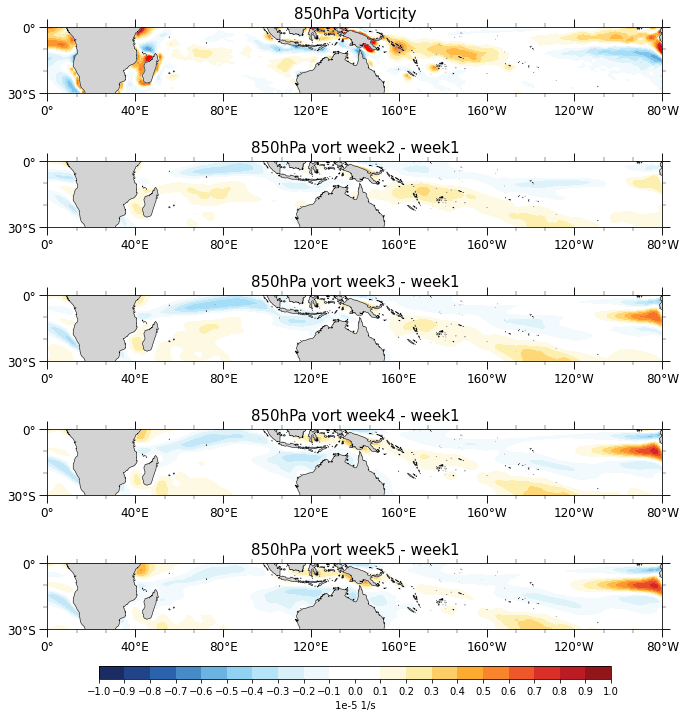

In [332]:
levels=np.linspace(-1,1, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot wind shear
var_plot_panels_winter(1e5*vo_n_winter[0],0,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"850hPa Vorticity", False)

for i in np.arange(1,5):
    var_plot_panels_winter(1e5*vo_n_winter_diff[i],i,0,ax1,levels,gvcmaps.BlueWhiteOrangeRed,"850hPa vort week"+(i+1).astype(str)+" - week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('1e-5 1/s')





#  GPI comparisons

In [80]:
dsg = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra_gpi_2002-2019.nc')
gpi_jra = dsg.gpi

In [81]:
gpi_jra

<xarray.DataArray 'gpi' (month: 12, latitude: 145, longitude: 288)>
[501120 values with dtype=float64]
Coordinates:
    number     int64 ...
    step       timedelta64[ns] ...
  * latitude   (latitude) float64 90.0 88.75 87.5 86.25 ... -87.5 -88.75 -90.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [87]:
dsg1 = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_gpi_2002-2018.nc')
gpi_era = dsg1.gpi

In [88]:
gpi_era

<xarray.DataArray 'gpi' (month: 12, latitude: 256, longitude: 512)>
[1572864 values with dtype=float64]
Coordinates:
    number     int64 ...
    step       timedelta64[ns] ...
  * latitude   (latitude) float64 89.46 88.77 88.07 ... -88.07 -88.77 -89.46
  * longitude  (longitude) float64 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [82]:
dsg_w1 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week1.nc')
gpi_w1 = dsg_w1.gpi

dsg_w2 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week2.nc')
gpi_w2 = dsg_w2.gpi

dsg_w3 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week3.nc')
gpi_w3 = dsg_w3.gpi

dsg_w4 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week4.nc')
gpi_w4 = dsg_w4.gpi

dsg_w5 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week5.nc')
gpi_w5 = dsg_w5.gpi

dsg_w6 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week6.nc')
gpi_w6 = dsg_w6.gpi

In [83]:
gpi_weeks = xr.concat([gpi_w1, gpi_w2, gpi_w3, gpi_w4, gpi_w5, gpi_w6],dim='week')

In [84]:
gpi_weeks['week'] = np.arange(1,7)

### regrid obs gpi to model grid

In [85]:
gpi_jra_regrid = gpi_jra.interp(latitude = dsg_w1.lat, longitude=dsg_w1.lon, method='linear')

In [89]:
gpi_era_regrid = gpi_era.interp(latitude = dsg_w1.lat, longitude = dsg_w1.lon, method='linear')

In [343]:
gpi_obs_diff = gpi_era_regrid.copy(data=gpi_era_regrid.data - gpi_jra_regrid.data)

In [86]:
gpi_mean_summer = gpi_weeks.sel(month=slice(6,10)).mean(('member','month'))
gpi_mean_winter = gpi_weeks.sel(month=[1,2,3,4,11,12]).mean(('member','month'))

In [90]:
gpi_era_mean_summer = gpi_era_regrid.sel(month=slice(6,10)).mean('month')
gpi_era_mean_winter = gpi_era_regrid.sel(month=[1,2,3,4,11,12]).mean('month')
gpi_jra_mean_summer =  gpi_jra_regrid.sel(month=slice(6,10)).mean('month')
gpi_jra_mean_winter = gpi_jra_regrid.sel(month=[1,2,3,4,11,12]).mean('month')

In [91]:
gpi_summer_diff = gpi_mean_summer.copy(data=gpi_mean_summer.data - gpi_jra_mean_summer.data)
gpi_winter_diff = gpi_mean_winter.copy(data=gpi_mean_winter.data - gpi_jra_mean_winter.data)

In [94]:
gpi_summer_diffm = gpi_summer_diff.copy(data=gpi_summer_diff.data - gpi_summer_diff.isel(week=0).data)
gpi_winter_diffm = gpi_winter_diff.copy(data=gpi_winter_diff.data - gpi_winter_diff.isel(week=0).data)

In [97]:
gpi_month_diff = gpi_weeks.mean('member').copy(data=gpi_weeks.mean('member').data - gpi_jra_regrid.data)

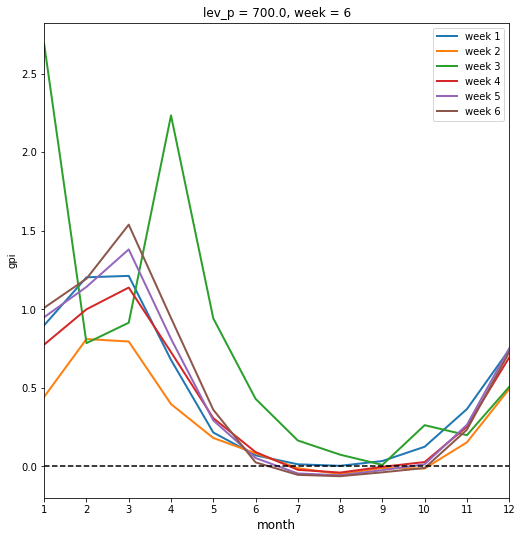

In [109]:
compare_climatology_bylead(gpi_month_diff,4)

## now let's plot a panel for all GPI differences

In [95]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 7,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot observations
var_plot_panels(gpi_jra_mean_summer,0,0,ax1,levels,gvcmaps.BlueYellowRed,"GPI_JRA55 summer", True)
var_plot_panels(gpi_summer_diff.isel(weeks=0),1,0,ax1,levels2,cmap,"GPI week1 minus JRA55", False)

for i in np.arange(1,5):
    var_plot_panels(gpi_summer_diffm[i],i+1,0,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i+1).astype(str)+" minus week1", False)

# add common colarbar
ax= fig.add_subplot(spec[6,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter
# plot observations
var_plot_panels_winter(gpi_jra_mean_winter,0,1,ax1,levels,gvcmaps.BlueYellowRed,"GPI_JRA55 winter", True)
var_plot_panels_winter(gpi_winter_diff.isel(weeks=0),1,1,ax1,levels2,cmap,"GPI week1 minus JRA55", False)

for i in np.arange(1,5):
    var_plot_panels_winter(gpi_winter_diffm[i],i+1,1,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i+1).astype(str)+" minus week1", False)

# add common colarbar
ax= fig.add_subplot(spec[6,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




NameError: name 'var_plot_panels' is not defined

<Figure size 1296x864 with 0 Axes>

## now what happens with each enviromental variable?

calculate GPI by replacing certain variable with observational data

In [424]:
# get observational terms
# regrid observational ps
t_vor_o = np.abs(1e5 * vo_regrid)**(3/2)  # s**-3/2
t_rh_o =  (rh700o_regrid / 50)**3 
t_pi_o =  (vmaxo_regrid / 70)**3   # m3 s-3
t_shear_o = (1 + 0.1 * shearo_regrid) ** -2    # m-2 s2

In [469]:
# get model terms
t_vor = S2S_vmax.copy(data=np.abs(1e5 * S2S_vo850)**(3/2))  # s**-3/2
t_rh =  S2S_vmax.copy(data=(S2S_rh700 / 50)**3)
t_pi =  S2S_vmax.copy(data=(S2S_vmax / 70)**3)   # m3 s-3
t_shear = S2S_vmax.copy(data=(1 + 0.1 * S2S_shear) ** -2)    # m-2 s2



In [472]:
t_vor_o.shape

(12, 192, 288)

In [475]:
# now get gpi with observational terms
gpi_vor = t_vor_o * t_rh * t_pi * t_shear
gpi_rh  = t_vor * t_rh_o * t_pi * t_shear
gpi_pi = t_vor * t_rh * t_pi_o * t_shear
gpi_shear = t_vor * t_rh * t_pi * t_shear_o

In [476]:
# get summer and winter member mean
gpi_vor_summer = gpi_vor.sel(month=slice(6,10)).mean(('member','month'))
gpi_vor_winter = gpi_vor.sel(month=[1,2,3,4,11,12]).mean(('member','month'))

gpi_rh_summer = gpi_rh.sel(month=slice(6,10)).mean(('member','month'))
gpi_rh_winter = gpi_rh.sel(month=[1,2,3,4,11,12]).mean(('member','month'))

gpi_pi_summer = gpi_pi.sel(month=slice(6,10)).mean(('member','month'))
gpi_pi_winter = gpi_pi.sel(month=[1,2,3,4,11,12]).mean(('member','month'))

gpi_shear_summer = gpi_shear.sel(month=slice(6,10)).mean(('member','month'))
gpi_shear_winter = gpi_shear.sel(month=[1,2,3,4,11,12]).mean(('member','month'))

In [500]:
# difference between gpi_vor and gpi 
# difference between gpi_vor week2 and gpi_vor week1, when vorticity is the same, difference between the two

gpi_vor_summer_diff = gpi_rh_summer.copy(data=gpi_vor_summer.transpose('week','lat','lon').data - gpi_mean_summer.data)
gpi_vor_winter_diff = gpi_rh_winter.copy(data=gpi_vor_winter.transpose('week','lat','lon').data - gpi_mean_winter.data)

gpi_rh_summer_diff = gpi_rh_summer.copy(data=gpi_rh_summer.data - gpi_mean_summer.data)
gpi_rh_winter_diff = gpi_rh_winter.copy(data=gpi_rh_winter.data - gpi_mean_winter.data)

gpi_pi_summer_diff = gpi_pi_summer.copy(data=gpi_pi_summer.data - gpi_mean_summer.data)
gpi_pi_winter_diff = gpi_pi_winter.copy(data=gpi_pi_winter.data - gpi_mean_winter.data)

gpi_shear_summer_diff = gpi_shear_summer.copy(data=gpi_shear_summer.data - gpi_mean_summer.data)
gpi_shear_winter_diff = gpi_shear_winter.copy(data=gpi_shear_winter.data - gpi_mean_winter.data)

In [392]:
gpi_summer_diffm = gpi_summer_diff.copy(data=gpi_summer_diff.data - gpi_summer_diff.isel(weeks=0).data)
gpi_winter_diffm = gpi_winter_diff.copy(data=gpi_winter_diff.data - gpi_winter_diff.isel(weeks=0).data)

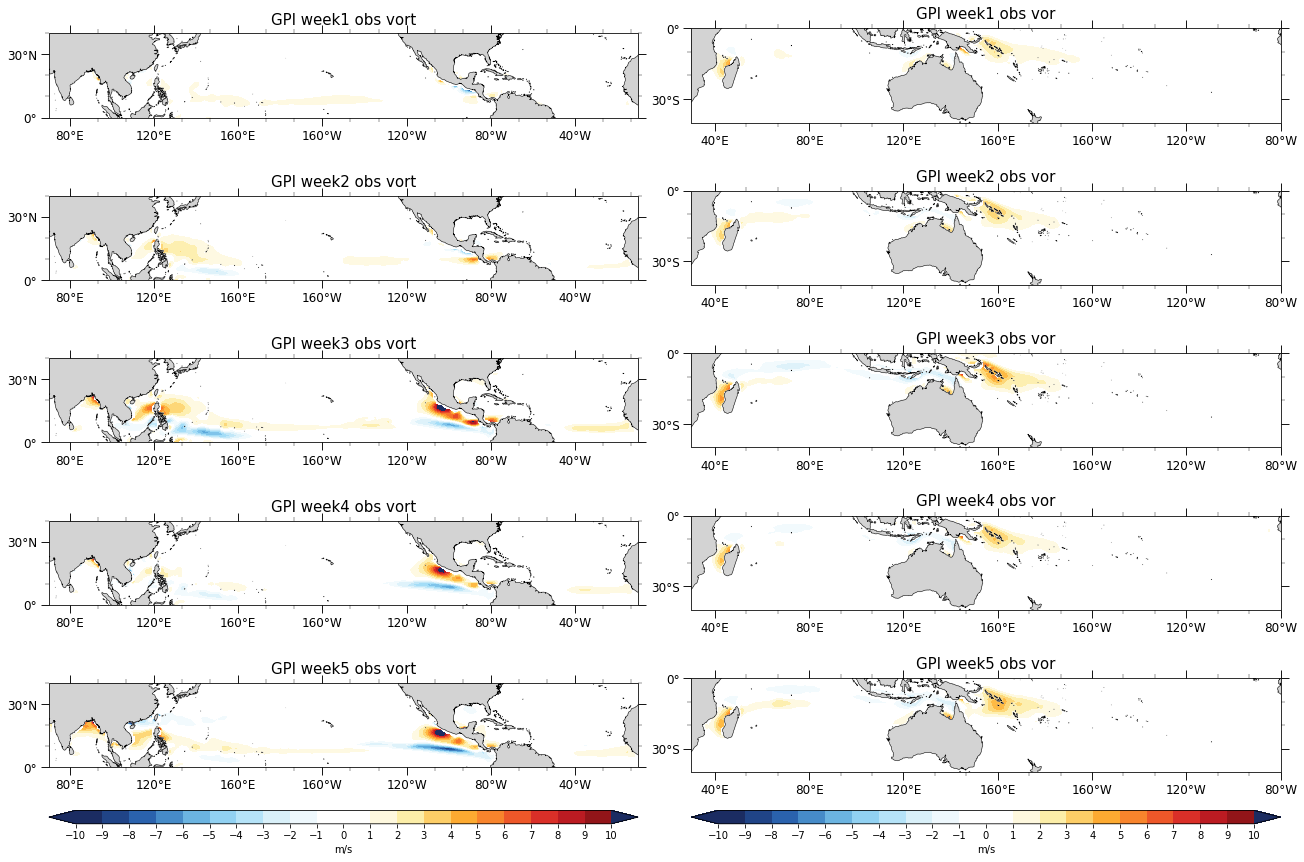

In [501]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1,  1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)


for i in np.arange(0,5):
    var_plot_panels(gpi_vor_summer_diff[i],i,0,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i+1).astype(str)+" obs vort", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter

for i in np.arange(0,5):
    var_plot_panels_winter(gpi_vor_winter_diff[i],i,1,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i+1).astype(str)+" obs vor", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




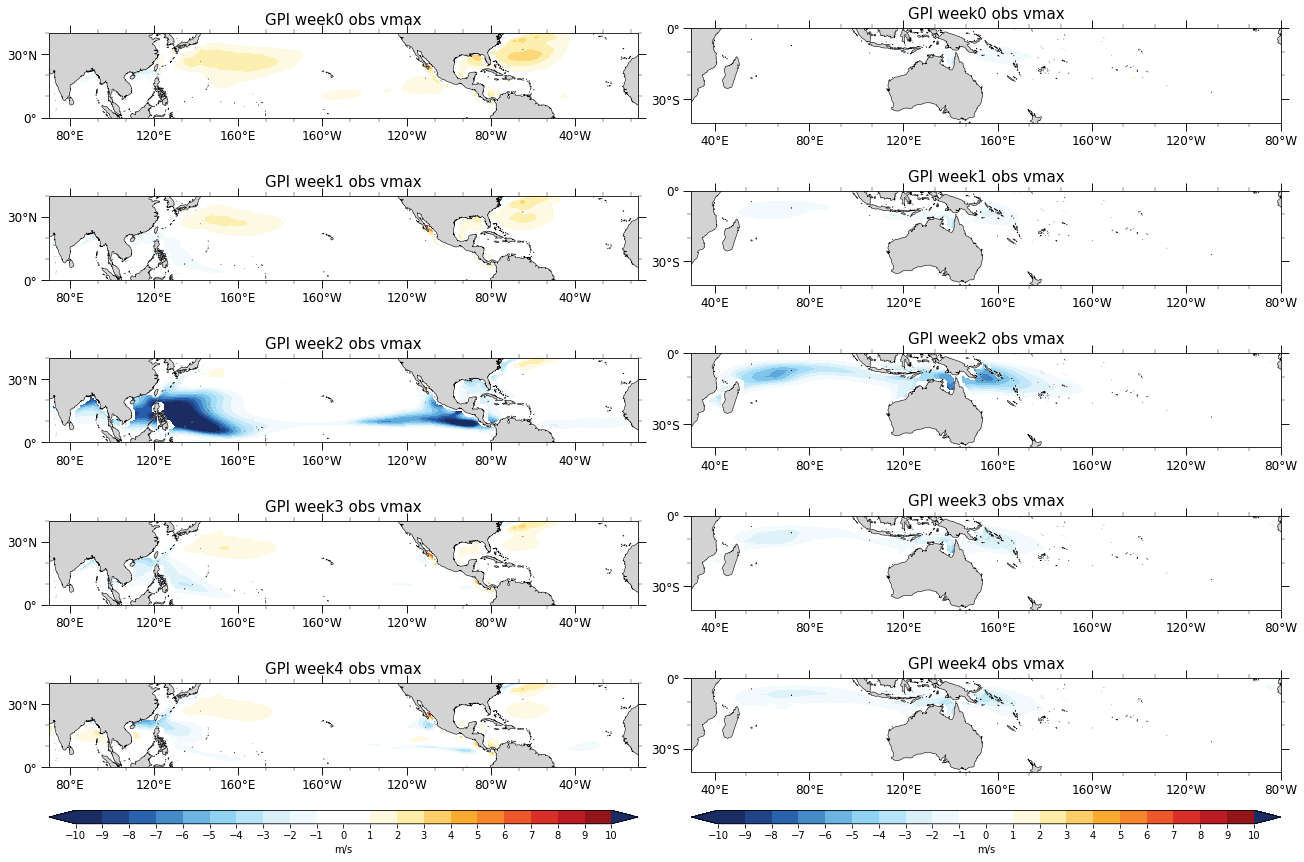

In [502]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1,  1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)


for i in np.arange(0,5):
    var_plot_panels(gpi_pi_summer_diff[i],i,0,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs vmax", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter

for i in np.arange(0,5):
    var_plot_panels_winter(gpi_pi_winter_diff[i],i,1,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs vmax", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




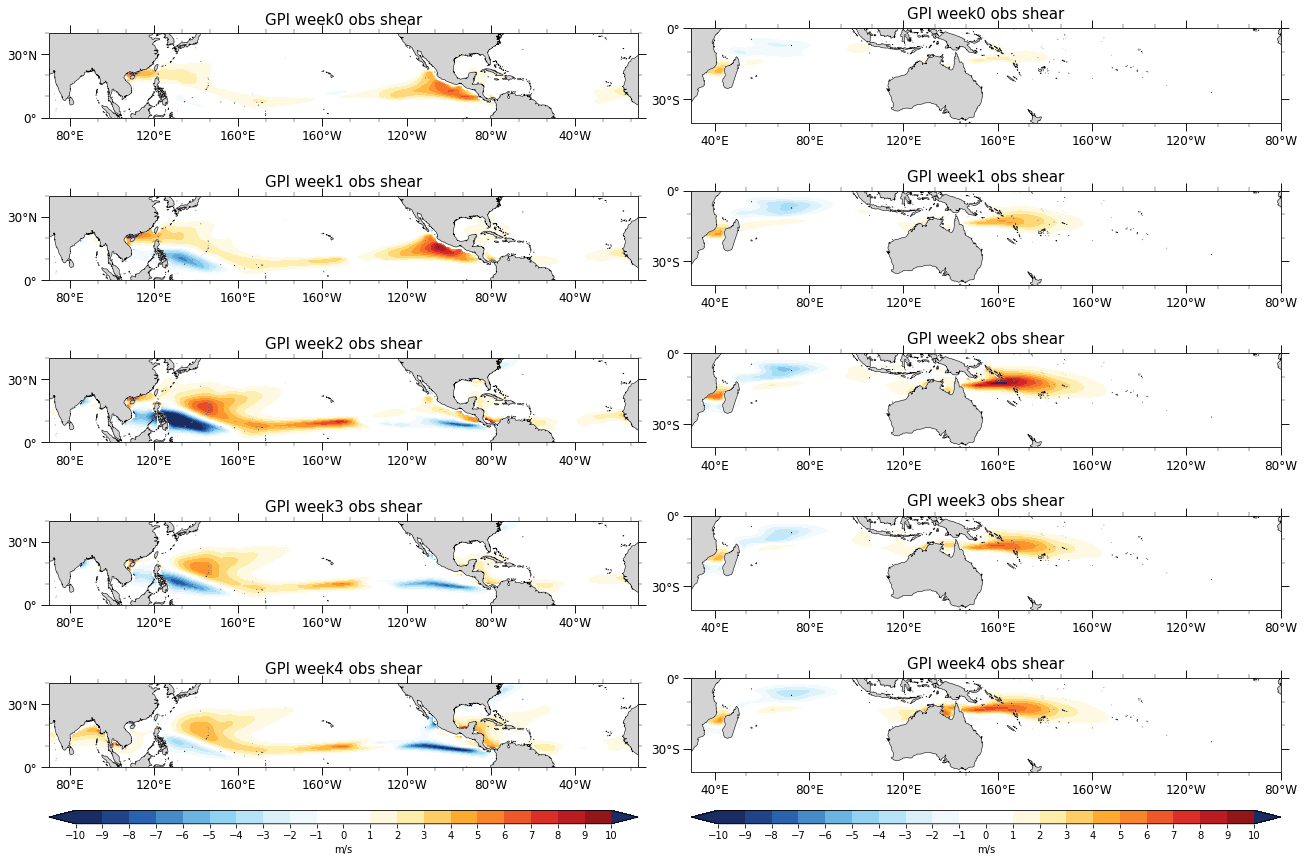

In [503]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1,  1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)


for i in np.arange(0,5):
    var_plot_panels(gpi_shear_summer_diff[i],i,0,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs shear", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter

for i in np.arange(0,5):
    var_plot_panels_winter(gpi_shear_winter_diff[i],i,1,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs shear", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




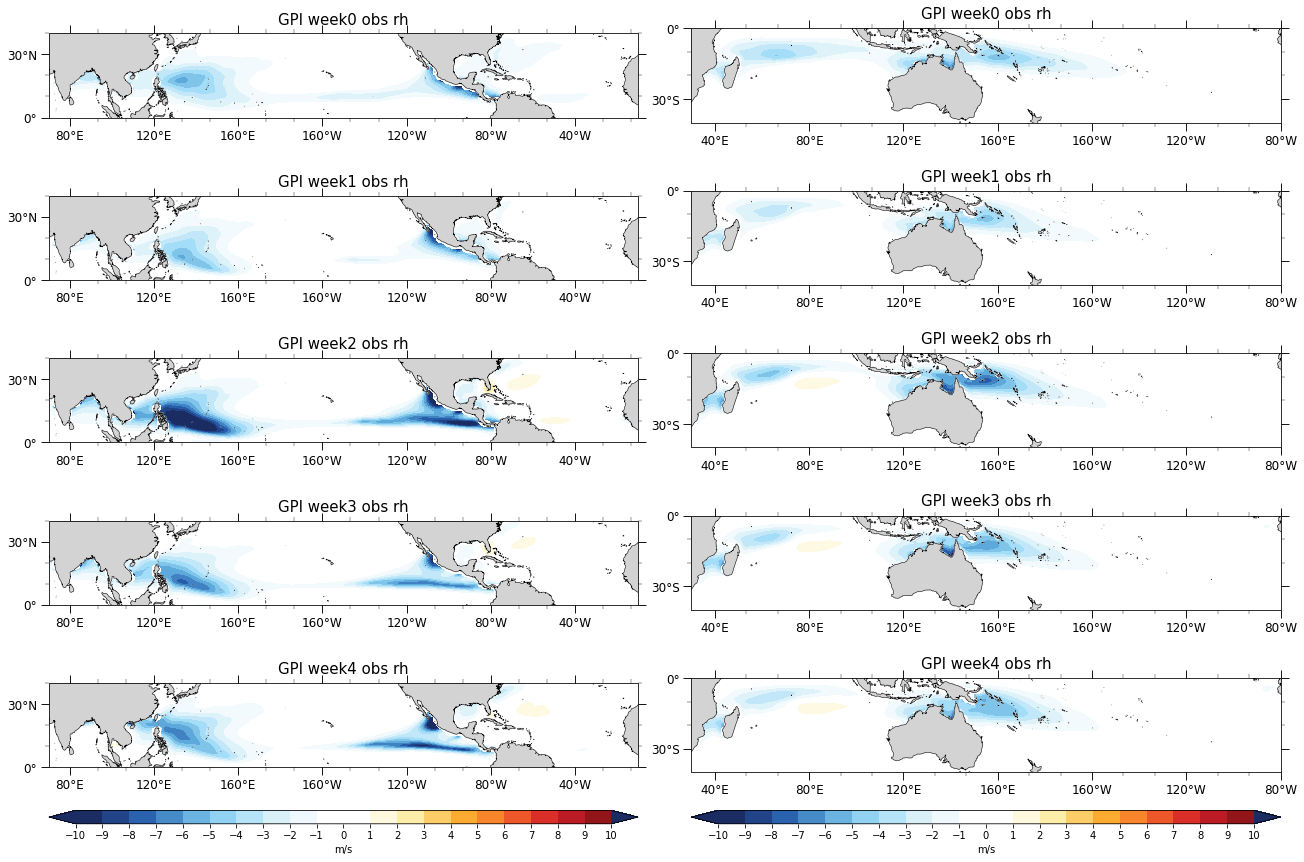

In [504]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1,  1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)


for i in np.arange(0,5):
    var_plot_panels(gpi_rh_summer_diff[i],i,0,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs rh", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter

for i in np.arange(0,5):
    var_plot_panels_winter(gpi_rh_winter_diff[i],i,1,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs rh", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')


